In [1]:
# Setting up google drive 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
import sys
sys.path.append('/content/gdrive/MyDrive/Colab Notebooks')

Mounted at /content/gdrive


In [2]:
import my_utils as mu
import torch
from torch import nn

# The Task

* Our **Task** for this week is to implement LeNet.
* The Learning Outcome: Hands-on application of PyTorch's API for creating and training CNNs.



# LeNet

* At a high level, LeNet (LeNet-5) consists of 2 parts:
    1. a convolutional encoder consisting of two convolutional layers; and
    2. a dense block consisting of three fully-connected layers;

![Data flow in LeNet. The input is a handwritten digit, the output a probability over 10 possible outcomes.](img/lenet.svg) 

<!-- ![Data flow in LeNet. The input is a handwritten digit, the output a probability over 10 possible outcomes.](https://drive.google.com/uc?export=view&id=18Kd-JNGeKp38qAVEuxEyYU7rjNudWdWA) -->   




# LeNet -- Convolutional Encoder

* Each convolutional *block*: 
    * A convolutional layer.
    * A sigmoid activation function (ReLUs were discovered recently).
    * A subsequent average pooling operation (max pooling was discovered later).
* Each convolutional layer uses a $5\times 5$ kernel.
* The first convolutional layer has 6 output channels, while the second has 16.
* Each $2\times2$ pooling operation (stride 2) reduces dimensionality by a factor of $4$ via spatial downsampling.
* The convolutional block emits an output with shape given by (batch size, number of channel, height, width).



# LeNet -- Dense Block

* In order to pass output from the convolutional block to the dense block, we must flatten each example in the minibatch.
* In other words, we take the four-dimensional input and transform it into the two-dimensional input expected by fully-connected layers:
    * the two-dimensional representation that we desire has uses the first dimension to index examples in the minibatch
    * the second to give the flat vector representation of each example.
* LeNet's dense block has three fully-connected layers, with 120, 84, and 10 outputs, respectively.
    * Because we are still performing classification, the 10-dimensional output layer corresponds to the number of possible output classes.

# Compressed LeNet Representation 


![Compressed notation for LeNet-5.](img/lenet-vert.svg)

<!-- ![Compressed notation for LeNet-5.](https://drive.google.com/uc?export=view&id=1Oh-SnOYVTCH0WZGbsGqzo1Mju6TYC8ue) -->


# Concise Implementation of LeNet

* Goal: use high-level APIs of PyTorch for implementing LeNet for classification. 

In [3]:
# Read training and test data
batch_size = 256
train_iter, test_iter = mu.load_data_fashion_mnist(batch_size)
# type(train_iter)

# Defining the Model

* We will modify the code from MLP




In [4]:
class LeNet(torch.nn.Module):
    def __init__(self, num_outputs):
        super(LeNet, self).__init__()
        self.Conv1 = nn.Conv2d(1, 6, 5, 1, 2)
        self.Sigma = nn.Sigmoid() 
        self.Avg = nn.AvgPool2d(2, stride=2, padding=0)
        self.Conv2 = nn.Conv2d(6, 16, 5, 1)
        self.Fl = nn.Flatten()
        self.Linear1 = nn.Linear(16*5*5, 120)
        self.Linear2 = nn.Linear(120, 84)
        self.Linear3 = nn.Linear(84, num_outputs) #num_outputs = 10
    
    def forward(self, x):
        out = self.Conv1(x)
        out = self.Sigma(out)
        out = self.Avg(out)
        out = self.Conv2(out)
        out = self.Sigma(out)
        out = self.Avg(out)
        out = self.Fl(out)
        out = self.Linear1(out)
        out = self.Sigma(out)
        out = self.Linear2(out)
        out = self.Sigma(out)
        out = self.Linear3(out)
        return out

In [5]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d: # by checking type we can init different layers in different ways
        torch.nn.init.xavier_uniform_(m.weight)          

num_outputs = 10
model = LeNet(num_outputs)

model.apply(init_weights);
print(model)

LeNet(
  (Conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (Sigma): Sigmoid()
  (Avg): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (Conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (Fl): Flatten()
  (Linear1): Linear(in_features=400, out_features=120, bias=True)
  (Linear2): Linear(in_features=120, out_features=84, bias=True)
  (Linear3): Linear(in_features=84, out_features=10, bias=True)
)


# Loss and Optimization Algorithm
* As in Softmax Regression

In [6]:
loss = nn.CrossEntropyLoss()
lr = 0.9
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# Training

* Use `my_utils.train_ch3` as in Softmax Regression

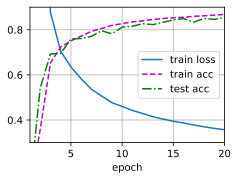

In [7]:
num_epochs = 20
mu.train_ch3(model, train_iter, test_iter, loss, num_epochs, optimizer)